In [145]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import Affine
from rasterio.enums import Resampling
import pandas as pd

import pds4_tools
from osgeo import gdal

from scipy import signal
from scipy.ndimage import gaussian_filter

In [267]:
def tiff2numpy(file):
    inds = rasterio.open(file)
    data = inds.read(1)
    inds.close()
    return data.astype(np.float32)

def resample(infile, height_scale_factor, width_scale_factor):
   
    with rasterio.open(infile) as dataset:

    # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * height_scale_factor),
                int(dataset.width * width_scale_factor)
            ),
            resampling=Resampling.bilinear
        )

        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )        
        return data[0]

In [296]:
tessera = "sudenitsa"
cprfile = "data2017/Clip_tessera_2017/"+tessera+"_cpr.tif"
incifile = "data2017/Clip_tessera_2017/"+tessera+"_inc.tif"
ocpfile = "data2017/Clip_tessera_2017/"+tessera+"_ocp_filt_norm.tif"
scpfile = "data2017/Clip_tessera_2017/"+tessera+"_scp_filt_norm.tif"
emisfile = "data2017/Clip_tessera_2017/"+tessera+"_emis.tif"
topofile = "data2017/Clip_tessera_2017/"+tessera+"_topo.tif"

In [297]:
cpr = tiff2numpy(cprfile)
inci = tiff2numpy(incifile)
ocp = tiff2numpy(ocpfile)
scp = tiff2numpy(scpfile)
emis = tiff2numpy(emisfile)
topo = (tiff2numpy(topofile) + 6051000) / 1e3
cpr = tiff2numpy(cprfile)

ht_scale = emis.shape[0]/cpr.shape[0]
wid_scale = emis.shape[1]/cpr.shape[1]

## resampling CPR before opening
cpr_r = resample(cprfile, ht_scale, wid_scale)
scp_r = resample(scpfile, ht_scale, wid_scale)
ocp_r = resample(ocpfile, ht_scale, wid_scale)
inci_r = resample(incifile, ht_scale, wid_scale)

In [298]:
print(emis.shape, scp_r.shape)
print(np.nanmax(cpr_r), np.nanmin(cpr_r), np.nanmean(cpr_r))

(329, 1075) (329, 1075)
9999.0 0.0 8418.019


In [299]:
cond = (np.abs(cpr_r)>1.5) | (emis<0.0)
topo[cond] = np.nan 
emis[cond] = np.nan
cpr_r[cond] = np.nan
scp_r[cond] = np.nan
ocp_r[cond] = np.nan

In [300]:
print(np.nanmax(cpr_r), np.nanmin(cpr_r), np.nanmean(cpr_r))

1.4909538 0.0 0.31796342


In [301]:
cpr1d = cpr_r.ravel()
# inci1d = inci_r.ravel()
ocp1d = ocp_r.ravel()
scp1d = scp_r.ravel()
emis1d = emis.ravel()
topo1d = topo.ravel()

In [302]:
mag_df = pd.DataFrame(np.array([topo1d, emis1d, cpr1d, ocp1d, scp1d]).T, columns = ["Elevation", "Emissivity", "CPR", "OC", "SC"])
mag_df.dropna()

,Elevation,Emissivity,CPR,OC,SC
11610,6052.866,0.8760,0.542712,2.403127e+00,6.002910e+00
11611,6052.816,0.8765,0.559429,2.394840e+00,6.124764e+00
11612,6052.781,0.8762,0.607550,2.321435e+00,6.358390e+00
12684,6052.733,0.8745,0.599960,2.219818e+00,6.286756e+00
12685,6052.738,0.8752,0.553156,2.345462e+00,6.002691e+00
...,...,...,...,...,...
318345,6051.979,0.8420,0.000000,1.188454e-20,4.199998e-19
318346,6052.035,0.8432,0.000000,1.188454e-20,4.199998e-19
319418,6052.010,0.8472,0.000000,1.188454e-20,4.199998e-19
319419,6051.962,0.8435,0.000000,1.188454e-20,4.199998e-19


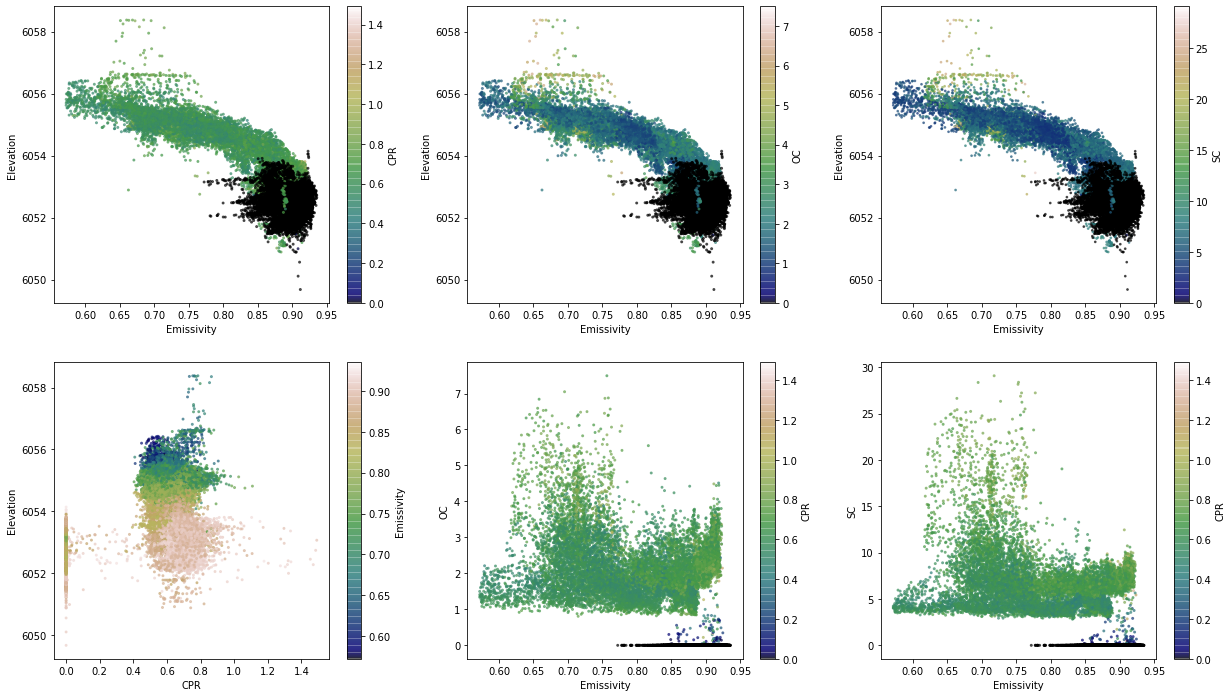

In [303]:
fig, ax = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(21, 12)

    
mag_df.plot.scatter('Emissivity', 'Elevation', c = 'CPR', cmap="gist_earth", alpha = 0.6, s=4, ax = ax[0,0])
# ax[0].set_ylim(mag_df.Elevation.min() - 1, mag_df.Elevation.max() + 1)
# ax[0,0].set_ylim(6048, mag_df.Elevation.max() + 1)

mag_df.plot.scatter('Emissivity', 'Elevation', c = 'OC', cmap="gist_earth", alpha = 0.6, s=4, ax = ax[0,1])
# ax[1].set_ylim(mag_df.Elevation.min() - 1, mag_df.Elevation.max() + 1)
# ax[0,1].set_ylim(6048, mag_df.Elevation.max() + 1)

mag_df.plot.scatter('Emissivity', 'Elevation', c = 'SC', cmap="gist_earth", alpha = 0.6, s=3, ax = ax[0,2])
# ax[2].set_ylim(mag_df.Elevation.min() - 1, mag_df.Elevation.max() + 1)
# ax[0,2].set_ylim(6048, mag_df.Elevation.max() + 1)

mag_df.plot.scatter('CPR', 'Elevation', c = 'Emissivity', cmap="gist_earth", alpha = 0.6, s=4, ax = ax[1,0])
# ax[1,0].set_ylim(6048, mag_df.Elevation.max() + 1)
mag_df.plot.scatter('Emissivity', 'OC', c = 'CPR', cmap="gist_earth", alpha = 0.6, s=4, ax = ax[1,1])
mag_df.plot.scatter('Emissivity', 'SC', c = 'CPR', cmap="gist_earth", alpha = 0.6, s=4, ax = ax[1,2])

plt.show()